In [1]:
!pip install speechbrain torchaudio torch librosa


In [7]:
import torchaudio
import torch
import speechbrain as sb
from speechbrain.inference import SpeakerRecognition
import os


In [9]:
# Load the pre-trained ECAPA-TDNN model from SpeechBrain
model = SpeakerRecognition.from_hparams(
    source="speechbrain/spkrec-ecapa-voxceleb",
    savedir="pretrained_models/spkrec-ecapa"
)


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
INFO:speechbrain.utils.fetching:Fetch custom.py: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
INFO:speechbrain.utils.fetching:Fetch label_encoder.txt: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
INFO:speechbrain.utils.parameter_transfer:Loading pretrained files for: embedding_model, mean_var_norm_emb, classifier, label_encoder


In [11]:
data_folder = "17paras"  # Folder where your speaker subfolders exist

# List all speaker directories
speakers = os.listdir(data_folder)
print("Detected speakers:", speakers)


Detected speakers: ['.ipynb_checkpoints', 'deepak', 'harika', 'likith', 'likta', 'macha', 'maimuna', 'manasa', 'nihar', 'nikith', 'pavan', 'rajesh', 'rno1', 'ruk', 'satwik', 'sup', 'vara', 'vijetha']


In [15]:
dataset_path = "17paras"

# Get list of speakers (folder names)
speakers = sorted(os.listdir(dataset_path))
speaker_to_id = {spk: i for i, spk in enumerate(speakers)}

# Load all data
data = []
labels = []

for speaker in speakers:
    speaker_folder = os.path.join(dataset_path, speaker)
    for filename in os.listdir(speaker_folder):
        if filename.endswith(".wav"):
            filepath = os.path.join(speaker_folder, filename)
            data.append(filepath)
            labels.append(speaker_to_id[speaker])

# Convert labels to tensor
labels = torch.tensor(labels)
print(f"Loaded {len(data)} audio files from {len(speakers)} speakers.")


Loaded 603 audio files from 18 speakers.


In [16]:
import torch
from speechbrain.inference import EncoderClassifier
import torchaudio

# Load the pre-trained ECAPA-TDNN model
classifier = EncoderClassifier.from_hparams(
    source="speechbrain/spkrec-ecapa-voxceleb",
    savedir="speechbrain_pretrained"
)

def extract_embeddings(file):
    """Extract ECAPA-TDNN embeddings and ensure consistent shape."""
    signal = classifier.load_audio(file)  # Load the audio
    embeddings = classifier.encode_batch(signal).detach()  # Get embeddings

    # Ensure shape is always [1, 192]
    embeddings = embeddings.squeeze(0)  # Remove batch dim
    if embeddings.dim() == 1:
        embeddings = embeddings.unsqueeze(0)  # Ensure (1, 192)

    return embeddings


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
INFO:speechbrain.utils.fetching:Fetch custom.py: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
INFO:speechbrain.utils.fetching:Fetch label_encoder.txt: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
INFO:speechbrain.utils.parameter_transfer:Loading pretrained files for: embedding_model, mean_var_norm_emb, classifier, label_encoder


In [17]:
# Extract features with consistent shape
X = [extract_embeddings(file) for file in data]
X = torch.cat(X, dim=0)  # Concatenate correctly
y = torch.tensor(labels)

print("X Shape:", X.shape)  # Should be (num_samples, 192)
print("y Shape:", y.shape)  # Should be (num_samples,)


X Shape: torch.Size([603, 192])
y Shape: torch.Size([603])


C:\Users\DEEPAK\AppData\Local\Temp\ipykernel_19360\721886779.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(labels)


In [43]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Create dataset & dataloader
dataset = TensorDataset(X, y)
train_loader = DataLoader(dataset, batch_size=16, shuffle=True)

# Define classifier
class SpeakerClassifier(nn.Module):
    def __init__(self, input_size=192, num_classes=len(speakers)):
        super(SpeakerClassifier, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.fc(x)

# Initialize model, loss, optimizer
model = SpeakerClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the classifier
for epoch in range(40):  # 20 epochs
    total_loss = 0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")


Epoch 1, Loss: 29.4529
Epoch 2, Loss: 0.2332
Epoch 3, Loss: 0.0587
Epoch 4, Loss: 0.0382
Epoch 5, Loss: 0.0300
Epoch 6, Loss: 0.0245
Epoch 7, Loss: 0.0202
Epoch 8, Loss: 0.0173
Epoch 9, Loss: 0.0148
Epoch 10, Loss: 0.0128
Epoch 11, Loss: 0.0112
Epoch 12, Loss: 0.0100
Epoch 13, Loss: 0.0089
Epoch 14, Loss: 0.0079
Epoch 15, Loss: 0.0071
Epoch 16, Loss: 0.0064
Epoch 17, Loss: 0.0059
Epoch 18, Loss: 0.0054
Epoch 19, Loss: 0.0049
Epoch 20, Loss: 0.0046
Epoch 21, Loss: 0.0043
Epoch 22, Loss: 0.0039
Epoch 23, Loss: 0.0036
Epoch 24, Loss: 0.0034
Epoch 25, Loss: 0.0032
Epoch 26, Loss: 0.0030
Epoch 27, Loss: 0.0028
Epoch 28, Loss: 0.0026
Epoch 29, Loss: 0.0025
Epoch 30, Loss: 0.0023
Epoch 31, Loss: 0.0022
Epoch 32, Loss: 0.0021
Epoch 33, Loss: 0.0020
Epoch 34, Loss: 0.0019
Epoch 35, Loss: 0.0018
Epoch 36, Loss: 0.0017
Epoch 37, Loss: 0.0016
Epoch 38, Loss: 0.0015
Epoch 39, Loss: 0.0014
Epoch 40, Loss: 0.0014


In [70]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Create dataset & dataloader
dataset = TensorDataset(X, y)
train_loader = DataLoader(dataset, batch_size=16, shuffle=True)

# Define classifier
class SpeakerClassifier(nn.Module):
    def __init__(self, input_size=192, num_classes=len(speakers)):
        super(SpeakerClassifier, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.fc(x)

# Initialize model, loss, optimizer
model = SpeakerClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the classifier
for epoch in range(20):  # 20 epochs
    total_loss = 0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")


Epoch 1, Loss: 29.8161
Epoch 2, Loss: 0.1491
Epoch 3, Loss: 0.0546
Epoch 4, Loss: 0.0358
Epoch 5, Loss: 0.0274
Epoch 6, Loss: 0.0217
Epoch 7, Loss: 0.0180
Epoch 8, Loss: 0.0151
Epoch 9, Loss: 0.0130
Epoch 10, Loss: 0.0111
Epoch 11, Loss: 0.0097
Epoch 12, Loss: 0.0087
Epoch 13, Loss: 0.0076
Epoch 14, Loss: 0.0068
Epoch 15, Loss: 0.0061
Epoch 16, Loss: 0.0055
Epoch 17, Loss: 0.0050
Epoch 18, Loss: 0.0046
Epoch 19, Loss: 0.0042
Epoch 20, Loss: 0.0039


In [71]:
print("Speakers List:", speakers)


Speakers List: ['.ipynb_checkpoints', 'deepak', 'harika', 'likith', 'likta', 'macha', 'maimuna', 'manasa', 'nihar', 'nikith', 'pavan', 'rajesh', 'rno1', 'ruk', 'satwik', 'sup', 'vara', 'vijetha']


In [72]:
def predict_speaker(model, classifier, audio_path):
    # Extract embedding
    embedding = extract_embeddings(audio_path) # Pass only the audio_path
    print("Embedding Shape:", embedding.shape)  # Expected (192,) or (256,)

    # Ensure embedding is in the correct format
    embedding = embedding.unsqueeze(0)  # Shape should be (1, 192) or (1, 256)
    print("Reshaped Embedding Shape:", embedding.shape)

    # Get model output
    with torch.no_grad():
        output = model(embedding)
        print("Model Output Shape:", output.shape)  # Expected (1, num_speakers)

    # Debug: Print full output tensor
    print("Model Raw Output:", output)

    # Get the predicted label
    pred_label = torch.argmax(output, dim=-1).item()
    print("Predicted Label Index:", pred_label)

    # Check if pred_label is valid
    if pred_label >= len(speakers):
        print("Error: Predicted label out of range!")
        return "Unknown"

    return speakers[pred_label]

In [73]:
test_audio = "17paras/likith/lik_1.wav"
predicted_speaker = predict_speaker(model, classifier, test_audio)
print(f"Predicted Speaker: {predicted_speaker}")

Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 18])
Model Raw Output: tensor([[[-10.2735,  -4.5327,  -6.3374,  12.7525,  -0.7987,   1.0738,  -9.4011,
           -3.4586,   1.0701,  -2.3468,   4.7494,   1.0715,  -3.1335,  -2.7711,
            1.9931,  -1.3675,  -6.2056,  -1.6441]]])
Predicted Label Index: 3
Predicted Speaker: likith


Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 18])
Model Raw Output: tensor([[[-8.2722,  2.4743, -2.7410,  1.4582, -3.6348, -3.0698, -6.7030,
          -6.4339,  2.6832,  1.9525,  2.8084,  8.3893, -1.8746, -5.3146,
           1.9231, -6.2032, -9.7421, -9.4702]]])
Predicted Label Index: 11
Predicted Speaker: rajesh


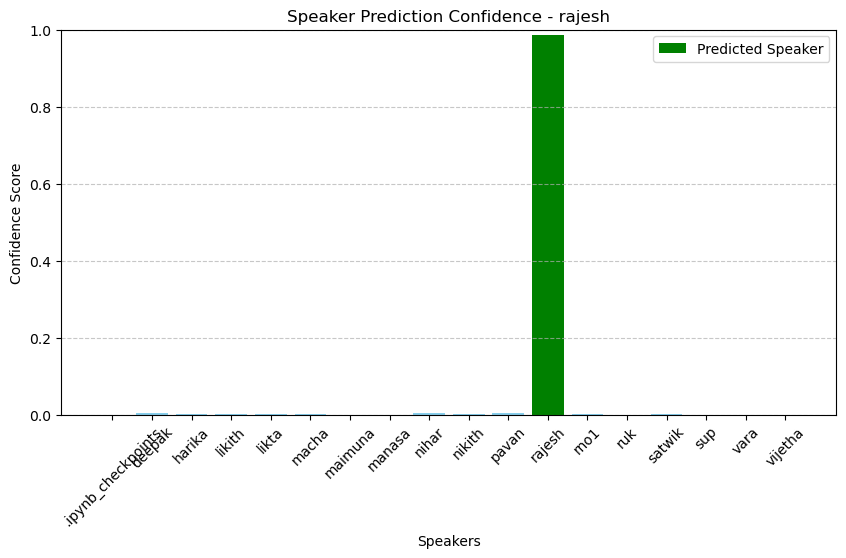

In [74]:
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# Call the existing function
test_audio = "test/newraj.wav"
predicted_speaker = predict_speaker(model, classifier, test_audio)
print(f"Predicted Speaker: {predicted_speaker}")

# Get model output again for confidence scores
with torch.no_grad():
    embedding = extract_embeddings(test_audio).unsqueeze(0)  # Ensure correct shape
    output = model(embedding)

# Apply softmax to convert logits into probabilities
softmax_probs = F.softmax(output, dim=-1).squeeze()  # Remove extra dimensions if needed
softmax_probs = softmax_probs.cpu().numpy()  # Convert only after calling .cpu()

# Plot confidence scores
plt.figure(figsize=(10, 5))
plt.bar(np.arange(len(speakers)), softmax_probs, color='skyblue')
plt.xticks(np.arange(len(speakers)), speakers, rotation=45)
plt.ylabel("Confidence Score")
plt.xlabel("Speakers")
plt.title(f"Speaker Prediction Confidence - {predicted_speaker}")
plt.ylim(0, 1)  # Confidence scores range from 0 to 1
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Highlight the predicted speaker
pred_label = np.argmax(softmax_probs)
plt.bar(pred_label, softmax_probs[pred_label], color='green', label="Predicted Speaker")
plt.legend()

# Show the plot
plt.show()



🔍 Predicted Speaker: likith (Confidence: 0.3847)

📊 Confidence Scores for Each Speaker:
.ipynb_checkpoints: 0.0003
deepak: 0.0008
harika: 0.0003
likith: 0.3847
likta: 0.0078
macha: 0.0184
maimuna: 0.0000
manasa: 0.0021
nihar: 0.0238
nikith: 0.1435
pavan: 0.3020
rajesh: 0.1122
rno1: 0.0010
ruk: 0.0002
satwik: 0.0024
sup: 0.0005
vara: 0.0001
vijetha: 0.0000


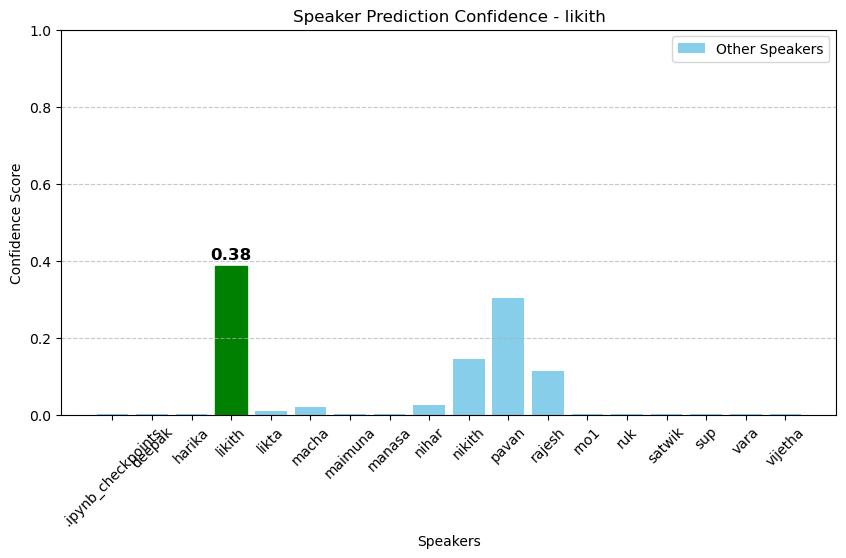

In [108]:
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# Define a threshold for unknown speakers
UNKNOWN_THRESHOLD = 0.3  # Adjust based on performance

def predict_speaker_with_confidence(model, classifier, audio_path):
    """Predict speaker with confidence score comparison."""
    embedding = extract_embeddings(audio_path).unsqueeze(0)  # Ensure correct shape

    with torch.no_grad():
        output = model(embedding)

    # Apply softmax for confidence scores
    softmax_probs = F.softmax(output, dim=-1).squeeze().cpu().numpy()

    # Get the most confident prediction
    pred_label = np.argmax(softmax_probs)
    confidence = softmax_probs[pred_label]

    # Handle unknown speakers
    if confidence < UNKNOWN_THRESHOLD:
        predicted_speaker = "Unknown"
    else:
        predicted_speaker = speakers[pred_label]

    print(f"\n🔍 Predicted Speaker: {predicted_speaker} (Confidence: {confidence:.4f})")

    # Print all confidence scores
    print("\n📊 Confidence Scores for Each Speaker:")
    for i, speaker in enumerate(speakers):
        print(f"{speaker}: {softmax_probs[i]:.4f}")

    # Plot confidence scores
    plt.figure(figsize=(10, 5))
    bars = plt.bar(np.arange(len(speakers)), softmax_probs, color='skyblue')
    plt.xticks(np.arange(len(speakers)), speakers, rotation=45)
    plt.ylabel("Confidence Score")
    plt.xlabel("Speakers")
    plt.title(f"Speaker Prediction Confidence - {predicted_speaker}")
    plt.ylim(0, 1)
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    # Highlight the predicted speaker
    if predicted_speaker != "Unknown":
        bars[pred_label].set_color('green')  # Change color to green
        plt.text(pred_label, softmax_probs[pred_label] + 0.02, f"{confidence:.2f}",
                 ha='center', fontsize=12, fontweight='bold')

    plt.legend(["Other Speakers", "Predicted Speaker"], loc="upper right")
    plt.show()

    return predicted_speaker, confidence

# Test with an audio file
test_audio = "test17.wav"
predicted_speaker, confidence = predict_speaker_with_confidence(model, classifier, test_audio)



In [75]:
import torch
import numpy as np
import sounddevice as sd
import scipy.io.wavfile as wav
import time

# Function to record audio
def record_audio(filename="realtime.wav", duration=5, sr=16000):
    print("🎤 Recording... Speak Now!")
    audio = sd.rec(int(duration * sr), samplerate=sr, channels=1, dtype="int16")
    sd.wait()
    wav.write(filename, sr, audio)
    print("✅ Recording saved as", filename)
    
    
def predict_speaker_realtime(model, classifier, audio_path):
    embedding = extract_embeddings(audio_path).unsqueeze(0).to(device)  # Shape: (1, 192)

    with torch.no_grad():
        outputs = model(embedding)  # Forward pass

        # Debugging: Print output shape
        print("\n🔹 Model Output Shape:", outputs.shape)

        # Ensure softmax is applied to a correct dimension
        softmax_probs = torch.nn.functional.softmax(outputs, dim=-1)  # Convert to probabilities
        
        # Debugging: Check softmax probabilities
        print("\n🔹 Softmax Probabilities Shape:", softmax_probs.shape)
        print("🔹 Softmax Probabilities:", softmax_probs.cpu().numpy())

        # Check if we have multiple speaker classes
        if softmax_probs.shape[1] < 2:
            print("❌ ERROR: Model did not output multiple class scores. Check training setup!")
            return "Unknown", 0.0  # Return default values if something is wrong

        pred_label = torch.argmax(softmax_probs, dim=-1).cpu().item()
        confidence = softmax_probs.squeeze(0)[pred_label].cpu().item() * 100

    print(f"\n🔊 Predicted Speaker: **{speakers[pred_label]}** (Confidence: {confidence:.2f}%)")
    return speakers[pred_label], confidence


# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Realtime Testing
record_audio("realtime.wav", duration=5)  # Record a 5-second audio sample
predicted_speaker, confidence = predict_speaker_realtime(model, classifier, "realtime.wav")



🎤 Recording... Speak Now!
✅ Recording saved as realtime.wav

🔹 Model Output Shape: torch.Size([1, 1, 18])

🔹 Softmax Probabilities Shape: torch.Size([1, 1, 18])
🔹 Softmax Probabilities: [[[4.3343312e-05 9.1625243e-01 3.0412972e-03 1.2651942e-02 2.4847861e-04
   2.8256897e-02 3.0778408e-06 5.9526943e-04 2.0720916e-02 6.2825568e-03
   1.1674721e-03 7.3735132e-03 2.5450918e-04 2.3021084e-05 2.6134080e-03
   4.3085284e-04 3.9209437e-05 1.7333737e-06]]]
❌ ERROR: Model did not output multiple class scores. Check training setup!


INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 18])
Model Raw Output: tensor([[[-7.6289, 10.3493, -1.3503, -3.3429, -2.4368,  3.7588, -3.1506,
          -4.0891,  1.2252, -2.7715, -2.2155, -0.9209, -1.7529, -4.5233,
           1.8699, -5.4171, -7.1299, -9.8016]]])
Predicted Label Index: 1
Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 18])
Model Raw Output: tensor([[[ -4.1258,  12.1999,   0.9666,  -5.2497,  -2.6514,   1.9149,  -3.0376,
           -3.2686,   0.6048,  -0.5622,  -3.0170,  -1.5685,  -2.2509,  -4.9379,
           -1.6342,  -2.8045,  -4.6630, -11.7208]]])
Predicted Label Index: 1
Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 18])
Model Raw Output: tensor([[[ -5.5978,  10.7670,  -1.3824,  -5.6347,  -3.5759,   1.7283,  -3.4667,
           -3.5

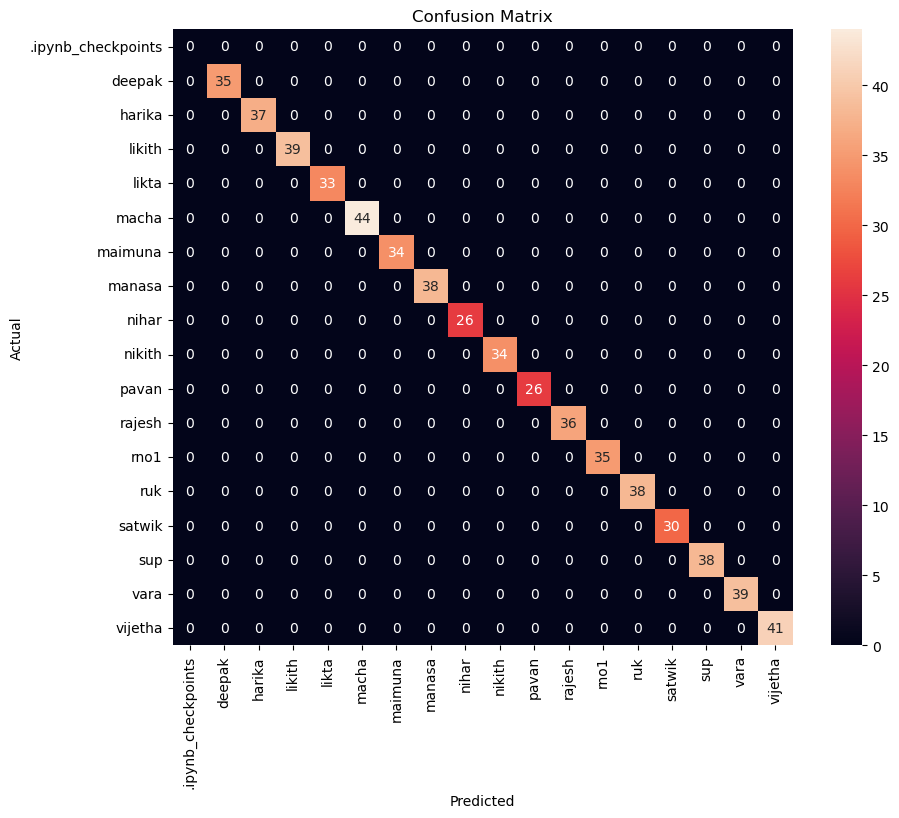

In [76]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

# Get predictions for all test samples
y_pred = [predict_speaker(model, classifier, file) for file in data]
y_true = [speakers[label] for label in labels.numpy()]

# Compute accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Plot confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred, labels=speakers)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, xticklabels=speakers, yticklabels=speakers, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [77]:
import sounddevice as sd
import scipy.io.wavfile as wav

def record_audio(filename="test.wav", duration=4, sr=16000):
    print("Recording...")
    audio = sd.rec(int(duration * sr), samplerate=sr, channels=1, dtype="int16")
    sd.wait()
    wav.write(filename, sr, audio)
    print("Recording saved.")

# Record and Predict
record_audio("test.wav", duration=4)
predicted_speaker = predict_speaker(model, classifier, "test.wav")
print(f"Predicted Speaker: {predicted_speaker}")


Recording...
Recording saved.
Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 18])
Model Raw Output: tensor([[[ -3.4055,   9.5244,   0.7983,  -4.8836,  -3.4049,  -0.1083,  -7.5336,
           -4.5838,  -0.3018,  -1.3863,  -0.6668,   0.0702,  -2.9629,  -5.2470,
            0.5496,  -1.1606,  -5.5136, -10.4498]]])
Predicted Label Index: 1
Predicted Speaker: deepak


In [79]:
import sounddevice as sd
import scipy.io.wavfile as wav

def record_audio(filename="test2.wav", duration=4, sr=16000):
    print("Recording...")
    audio = sd.rec(int(duration * sr), samplerate=sr, channels=1, dtype="int16")
    sd.wait()
    wav.write(filename, sr, audio)
    print("Recording saved.")

# Record and Predict
record_audio("test2.wav", duration=4)
predicted_speaker = predict_speaker(model, classifier, "test2.wav")
print(f"Predicted Speaker: {predicted_speaker}")


Recording...
Recording saved.
Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 18])
Model Raw Output: tensor([[[-10.2829,   5.9308,  -2.8565,   0.3548,  -2.0392,  -0.1621,  -6.9341,
           -4.6348,   3.2458,   1.5449,   2.6027,   8.0554,  -2.6147,  -5.0241,
           -0.0616,  -6.7205, -10.4584, -12.5231]]])
Predicted Label Index: 11
Predicted Speaker: rajesh


In [80]:
import sounddevice as sd
import scipy.io.wavfile as wav

def record_audio(filename="test3.wav", duration=4, sr=16000):
    print("Recording...")
    audio = sd.rec(int(duration * sr), samplerate=sr, channels=1, dtype="int16")
    sd.wait()
    wav.write(filename, sr, audio)
    print("Recording saved.")

# Record and Predict
record_audio("test3.wav", duration=4)
predicted_speaker = predict_speaker(model, classifier, "test3.wav")
print(f"Predicted Speaker: {predicted_speaker}")


Recording...
Recording saved.
Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 18])
Model Raw Output: tensor([[[-4.3096e+00,  9.3139e+00,  6.4875e-03, -3.8335e+00, -2.6378e+00,
           3.0214e+00, -5.2306e+00, -4.3891e+00, -4.3423e-01,  2.3726e-01,
          -6.8641e-01, -2.2593e+00, -2.8553e+00, -5.3711e+00, -2.5106e-01,
          -2.4848e+00, -4.4658e+00, -1.0404e+01]]])
Predicted Label Index: 1
Predicted Speaker: deepak


In [81]:
import sounddevice as sd
import scipy.io.wavfile as wav

def record_audio(filename="test4.wav", duration=4, sr=16000):
    print("Recording...")
    audio = sd.rec(int(duration * sr), samplerate=sr, channels=1, dtype="int16")
    sd.wait()
    wav.write(filename, sr, audio)
    print("Recording saved.")

# Record and Predict
record_audio("test4.wav", duration=4)
predicted_speaker = predict_speaker(model, classifier, "test4.wav")
print(f"Predicted Speaker: {predicted_speaker}")


Recording...
Recording saved.
Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 18])
Model Raw Output: tensor([[[-6.2918,  2.5267,  1.0131, -2.3594,  3.0109, -0.1817, -6.4075,
          -2.4621, -1.3193,  0.3228,  4.4931,  6.4973,  0.4180, -2.4757,
           1.9988, -1.4529, -5.1466, -3.5246]]])
Predicted Label Index: 11
Predicted Speaker: rajesh


In [82]:
import sounddevice as sd
import scipy.io.wavfile as wav

def record_audio(filename="test5.wav", duration=4, sr=16000):
    print("Recording...")
    audio = sd.rec(int(duration * sr), samplerate=sr, channels=1, dtype="int16")
    sd.wait()
    wav.write(filename, sr, audio)
    print("Recording saved.")

# Record and Predict
record_audio("test5.wav", duration=4)
predicted_speaker = predict_speaker(model, classifier, "test5.wav")
print(f"Predicted Speaker: {predicted_speaker}")


Recording...
Recording saved.
Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 18])
Model Raw Output: tensor([[[-5.3493, -2.0684, -2.3580,  2.3031, -2.0168, -0.4457, -1.6714,
           0.3903,  2.7898,  2.4296, -1.0848, -0.1920, -2.0781, -3.6708,
           2.0410, -0.9491, -4.4270, -4.2032]]])
Predicted Label Index: 8
Predicted Speaker: nihar


In [83]:
import sounddevice as sd
import scipy.io.wavfile as wav

def record_audio(filename="test6.wav", duration=6, sr=16000):
    print("Recording...")
    audio = sd.rec(int(duration * sr), samplerate=sr, channels=1, dtype="int16")
    sd.wait()
    wav.write(filename, sr, audio)
    print("Recording saved.")

# Record and Predict
record_audio("test6.wav", duration=4)
predicted_speaker = predict_speaker(model, classifier, "test6.wav")
print(f"Predicted Speaker: {predicted_speaker}")

Recording...
Recording saved.
Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 18])
Model Raw Output: tensor([[[-2.6069, -2.5162, -4.1322, -3.4544,  4.7972, -5.0187, -3.5914,
           0.3804,  0.1591, -5.1875, -2.9334, -7.2760, -1.1836, -3.2749,
          -5.1866, -1.5730, -2.0376,  4.9015]]])
Predicted Label Index: 17
Predicted Speaker: vijetha


In [84]:
import sounddevice as sd
import scipy.io.wavfile as wav

def record_audio(filename="test7.wav", duration=6, sr=16000):
    print("Recording...")
    audio = sd.rec(int(duration * sr), samplerate=sr, channels=1, dtype="int16")
    sd.wait()
    wav.write(filename, sr, audio)
    print("Recording saved.")

# Record and Predict
record_audio("test7.wav", duration=4)
predicted_speaker = predict_speaker(model, classifier, "test7.wav")
print(f"Predicted Speaker: {predicted_speaker}")

Recording...
Recording saved.
Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 18])
Model Raw Output: tensor([[[-9.5699, -1.5032, -1.7542,  8.8838,  0.8159,  1.4103, -7.5883,
          -0.7107,  0.9785,  2.3922,  3.9550,  2.8636, -3.3461, -3.5764,
           0.5486, -2.4888, -5.0447, -4.9577]]])
Predicted Label Index: 3
Predicted Speaker: likith


In [85]:
import sounddevice as sd
import scipy.io.wavfile as wav

def record_audio(filename="test8.wav", duration=4, sr=16000):
    print("Recording...")
    audio = sd.rec(int(duration * sr), samplerate=sr, channels=1, dtype="int16")
    sd.wait()
    wav.write(filename, sr, audio)
    print("Recording saved.")

# Record and Predict
record_audio("test8.wav", duration=4)
predicted_speaker = predict_speaker(model, classifier, "test8.wav")
print(f"Predicted Speaker: {predicted_speaker}")

Recording...
Recording saved.
Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 18])
Model Raw Output: tensor([[[-5.1728, 10.0539,  2.6863, -4.3318, -2.2979,  0.6469, -7.5268,
          -3.1269, -0.8553, -3.2366, -1.3193, -2.7976, -2.7087, -4.6373,
           0.1920, -0.3025, -3.4347, -8.8519]]])
Predicted Label Index: 1
Predicted Speaker: deepak


In [86]:
import sounddevice as sd
import scipy.io.wavfile as wav

def record_audio(filename="test9.wav", duration=4, sr=16000):
    print("Recording...")
    audio = sd.rec(int(duration * sr), samplerate=sr, channels=1, dtype="int16")
    sd.wait()
    wav.write(filename, sr, audio)
    print("Recording saved.")

# Record and Predict
record_audio("test9.wav", duration=4)
predicted_speaker = predict_speaker(model, classifier, "test9.wav")
print(f"Predicted Speaker: {predicted_speaker}")

Recording...
Recording saved.
Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 18])
Model Raw Output: tensor([[[ -8.7778,  -3.3772,  -0.0308,   5.3794,   1.7522,   5.6738, -12.4194,
           -1.1307,  -2.8031,   4.0966,   4.5743,   1.8595,  -2.1301,  -6.1677,
            1.0531,  -3.1229,  -4.2588,  -3.8301]]])
Predicted Label Index: 5
Predicted Speaker: macha


In [87]:
import sounddevice as sd
import scipy.io.wavfile as wav

def record_audio(filename="test10.wav", duration=4, sr=16000):
    print("Recording...")
    audio = sd.rec(int(duration * sr), samplerate=sr, channels=1, dtype="int16")
    sd.wait()
    wav.write(filename, sr, audio)
    print("Recording saved.")

# Record and Predict
record_audio("test10.wav", duration=4)
predicted_speaker = predict_speaker(model, classifier, "test10.wav")
print(f"Predicted Speaker: {predicted_speaker}")

Recording...
Recording saved.
Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 18])
Model Raw Output: tensor([[[-6.9293, -1.3297, -1.8180,  5.8025,  0.1090, -0.3546, -5.8164,
           0.7379,  1.0603, -1.0995,  2.5678, -0.5621, -2.5271, -3.2377,
           0.7603, -1.2537, -3.8693, -2.5452]]])
Predicted Label Index: 3
Predicted Speaker: likith


In [88]:
import sounddevice as sd
import scipy.io.wavfile as wav

def record_audio(filename="test11.wav", duration=4, sr=16000):
    print("Recording...")
    audio = sd.rec(int(duration * sr), samplerate=sr, channels=1, dtype="int16")
    sd.wait()
    wav.write(filename, sr, audio)
    print("Recording saved.")

# Record and Predict
record_audio("test11.wav", duration=4)
predicted_speaker = predict_speaker(model, classifier, "test11.wav")
print(f"Predicted Speaker: {predicted_speaker}")

Recording...
Recording saved.
Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 18])
Model Raw Output: tensor([[[-7.3493,  1.8515, -1.9337,  2.2466, -3.3708, -1.4038, -6.7577,
          -4.0252,  1.4858, -0.2790,  2.1139,  8.0918, -0.0823, -1.4181,
          -2.2218, -5.1548, -6.0691, -6.7715]]])
Predicted Label Index: 11
Predicted Speaker: rajesh


In [89]:
import sounddevice as sd
import scipy.io.wavfile as wav

def record_audio(filename="test12.wav", duration=4, sr=16000):
    print("Recording...")
    audio = sd.rec(int(duration * sr), samplerate=sr, channels=1, dtype="int16")
    sd.wait()
    wav.write(filename, sr, audio)
    print("Recording saved.")

# Record and Predict
record_audio("test12.wav", duration=4)
predicted_speaker = predict_speaker(model, classifier, "test12.wav")
print(f"Predicted Speaker: {predicted_speaker}")

Recording...
Recording saved.
Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 18])
Model Raw Output: tensor([[[-6.6483,  9.4687,  2.2337, -4.4994, -1.2850,  1.0944, -6.3400,
          -2.6303, -0.2122, -3.8814, -1.1449, -2.4874, -3.7259, -5.1893,
           3.2862, -2.3941, -6.1221, -7.7472]]])
Predicted Label Index: 1
Predicted Speaker: deepak


In [90]:
import sounddevice as sd
import scipy.io.wavfile as wav

def record_audio(filename="test13.wav", duration=4, sr=16000):
    print("Recording...")
    audio = sd.rec(int(duration * sr), samplerate=sr, channels=1, dtype="int16")
    sd.wait()
    wav.write(filename, sr, audio)
    print("Recording saved.")

# Record and Predict
record_audio("test13.wav", duration=4)
predicted_speaker = predict_speaker(model, classifier, "test13.wav")
print(f"Predicted Speaker: {predicted_speaker}")

Recording...
Recording saved.
Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 18])
Model Raw Output: tensor([[[-8.0260e+00,  4.7756e-03, -1.2779e+00, -3.3243e-01, -8.0299e-01,
           1.7538e+00, -8.1058e+00, -3.0739e-02, -2.3676e+00, -2.7932e+00,
           1.9094e+00,  4.1355e+00, -5.5067e-01, -1.5868e+00, -2.3248e-01,
          -3.5377e+00, -3.3437e+00, -6.6573e+00]]])
Predicted Label Index: 11
Predicted Speaker: rajesh


In [91]:
import sounddevice as sd
import scipy.io.wavfile as wav

def record_audio(filename="test14.wav", duration=4, sr=16000):
    print("Recording...")
    audio = sd.rec(int(duration * sr), samplerate=sr, channels=1, dtype="int16")
    sd.wait()
    wav.write(filename, sr, audio)
    print("Recording saved.")

# Record and Predict
record_audio("test14.wav", duration=4)
predicted_speaker = predict_speaker(model, classifier, "test14.wav")
print(f"Predicted Speaker: {predicted_speaker}")

Recording...
Recording saved.
Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 18])
Model Raw Output: tensor([[[-1.9838, -0.2204,  0.6155, -0.1354,  3.9239, -2.9370, -2.9801,
           1.3606,  1.7684, -2.0436,  1.6190, -1.4143, -2.6262, -3.7387,
           2.1848, -1.1800, -3.7791,  0.0938]]])
Predicted Label Index: 4
Predicted Speaker: likta


In [92]:
import sounddevice as sd
import scipy.io.wavfile as wav

def record_audio(filename="test15.wav", duration=4, sr=16000):
    print("Recording...")
    audio = sd.rec(int(duration * sr), samplerate=sr, channels=1, dtype="int16")
    sd.wait()
    wav.write(filename, sr, audio)
    print("Recording saved.")

# Record and Predict
record_audio("test15.wav", duration=4)
predicted_speaker = predict_speaker(model, classifier, "test15.wav")
print(f"Predicted Speaker: {predicted_speaker}")

Recording...
Recording saved.
Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 18])
Model Raw Output: tensor([[[-4.0077, -3.1431, -0.5932,  1.2365, -0.0877, -4.5913, -4.2608,
          -2.3171,  2.6101,  1.0824, -0.5879, -0.5499, -3.1420, -3.9610,
           1.3725,  0.5245, -1.3431, -5.3027]]])
Predicted Label Index: 8
Predicted Speaker: nihar


In [93]:
import sounddevice as sd
import scipy.io.wavfile as wav

def record_audio(filename="test16.wav", duration=4, sr=16000):
    print("Recording...")
    audio = sd.rec(int(duration * sr), samplerate=sr, channels=1, dtype="int16")
    sd.wait()
    wav.write(filename, sr, audio)
    print("Recording saved.")

# Record and Predict
record_audio("test16.wav", duration=4)
predicted_speaker = predict_speaker(model, classifier, "test16.wav")
print(f"Predicted Speaker: {predicted_speaker}")

Recording...
Recording saved.
Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 18])
Model Raw Output: tensor([[[-1.9927,  1.7455, -0.6816, -1.0542, -0.3119,  0.1917, -4.2923,
          -0.2436,  0.8797,  0.8942, -0.5278, -0.5921, -2.4092, -3.1725,
          -0.7541, -0.1010, -1.8408, -6.3295]]])
Predicted Label Index: 1
Predicted Speaker: deepak


In [94]:
import sounddevice as sd
import scipy.io.wavfile as wav

def record_audio(filename="test17.wav", duration=4, sr=16000):
    print("Recording...")
    audio = sd.rec(int(duration * sr), samplerate=sr, channels=1, dtype="int16")
    sd.wait()
    wav.write(filename, sr, audio)
    print("Recording saved.")

# Record and Predict
record_audio("test17.wav", duration=4)
predicted_speaker = predict_speaker(model, classifier, "test17.wav")
print(f"Predicted Speaker: {predicted_speaker}")

Recording...
Recording saved.
Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 18])
Model Raw Output: tensor([[[-3.7630, -2.6711, -3.5955,  3.5506, -0.3468,  0.5078, -5.7842,
          -1.6454,  0.7675,  2.5646,  3.3086,  2.3180, -2.4352, -3.8305,
          -1.5197, -3.1605, -4.9354, -5.7126]]])
Predicted Label Index: 3
Predicted Speaker: likith


In [95]:
import sounddevice as sd
import scipy.io.wavfile as wav

def record_audio(filename="test18.wav", duration=4, sr=16000):
    print("Recording...")
    audio = sd.rec(int(duration * sr), samplerate=sr, channels=1, dtype="int16")
    sd.wait()
    wav.write(filename, sr, audio)
    print("Recording saved.")

# Record and Predict
record_audio("test18.wav", duration=4)
predicted_speaker = predict_speaker(model, classifier, "test18.wav")
print(f"Predicted Speaker: {predicted_speaker}")

Recording...
Recording saved.
Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 18])
Model Raw Output: tensor([[[-5.7269, -1.7568, -3.0669,  6.3813, -2.4554,  0.3620, -6.9833,
          -3.0954,  5.1714,  2.4846, -0.7573,  2.2688, -2.9850, -4.6465,
          -1.3765, -4.3008, -6.1133, -5.3080]]])
Predicted Label Index: 3
Predicted Speaker: likith


In [96]:
import sounddevice as sd
import scipy.io.wavfile as wav

def record_audio(filename="test19.wav", duration=4, sr=16000):
    print("Recording...")
    audio = sd.rec(int(duration * sr), samplerate=sr, channels=1, dtype="int16")
    sd.wait()
    wav.write(filename, sr, audio)
    print("Recording saved.")

# Record and Predict
record_audio("test19.wav", duration=4)
predicted_speaker = predict_speaker(model, classifier, "test19.wav")
print(f"Predicted Speaker: {predicted_speaker}")

Recording...
Recording saved.
Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 18])
Model Raw Output: tensor([[[-7.8823,  4.0382, -1.1711, -3.9061, -0.9738, -0.7684, -9.9120,
          -5.4907, -2.1373, -1.2138,  4.9578,  4.6058, -2.1259, -5.2050,
           1.5695, -4.8409, -8.6063, -9.0479]]])
Predicted Label Index: 10
Predicted Speaker: pavan


In [97]:
import sounddevice as sd
import scipy.io.wavfile as wav

def record_audio(filename="test20.wav", duration=4, sr=16000):
    print("Recording...")
    audio = sd.rec(int(duration * sr), samplerate=sr, channels=1, dtype="int16")
    sd.wait()
    wav.write(filename, sr, audio)
    print("Recording saved.")

# Record and Predict
record_audio("test20.wav", duration=4)
predicted_speaker = predict_speaker(model, classifier, "test20.wav")
print(f"Predicted Speaker: {predicted_speaker}")

Recording...
Recording saved.
Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 18])
Model Raw Output: tensor([[[-7.6960,  2.7121, -4.1413, -0.5047, -3.1593, -1.0860, -4.4064,
          -7.7801,  0.0527, -2.0727, -0.6405,  4.6656, -1.9181, -5.2286,
           4.1356, -3.1777, -7.0679, -5.0980]]])
Predicted Label Index: 11
Predicted Speaker: rajesh


In [98]:
import sounddevice as sd
import scipy.io.wavfile as wav

def record_audio(filename="test21.wav", duration=4, sr=16000):
    print("Recording...")
    audio = sd.rec(int(duration * sr), samplerate=sr, channels=1, dtype="int16")
    sd.wait()
    wav.write(filename, sr, audio)
    print("Recording saved.")

# Record and Predict
record_audio("test21.wav", duration=4)
predicted_speaker = predict_speaker(model, classifier, "test21.wav")
print(f"Predicted Speaker: {predicted_speaker}")

Recording...
Recording saved.
Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 18])
Model Raw Output: tensor([[[-7.6372,  6.4830,  2.8437, -3.7534,  0.4513,  0.1999, -7.6825,
          -2.4858,  0.5438, -0.7386,  1.0944, -1.0438, -3.8760, -5.6316,
           2.3551, -0.8269, -4.8510, -8.0707]]])
Predicted Label Index: 1
Predicted Speaker: deepak


In [99]:
import sounddevice as sd
import scipy.io.wavfile as wav

def record_audio(filename="test22.wav", duration=4, sr=16000):
    print("Recording...")
    audio = sd.rec(int(duration * sr), samplerate=sr, channels=1, dtype="int16")
    sd.wait()
    wav.write(filename, sr, audio)
    print("Recording saved.")

# Record and Predict
record_audio("test22.wav", duration=4)
predicted_speaker = predict_speaker(model, classifier, "test22.wav")
print(f"Predicted Speaker: {predicted_speaker}")

Recording...
Recording saved.
Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 18])
Model Raw Output: tensor([[[-6.1822, -2.0056, -3.2309,  6.0710, -1.1573, -2.8875, -2.3353,
          -1.8862,  3.4634,  1.3296,  1.1955, -0.9401, -2.8592, -1.2746,
           0.5693,  0.3170, -1.4674, -4.5372]]])
Predicted Label Index: 3
Predicted Speaker: likith


In [109]:
import os
print(os.getcwd())  # Check current directory


C:\Windows\System32
